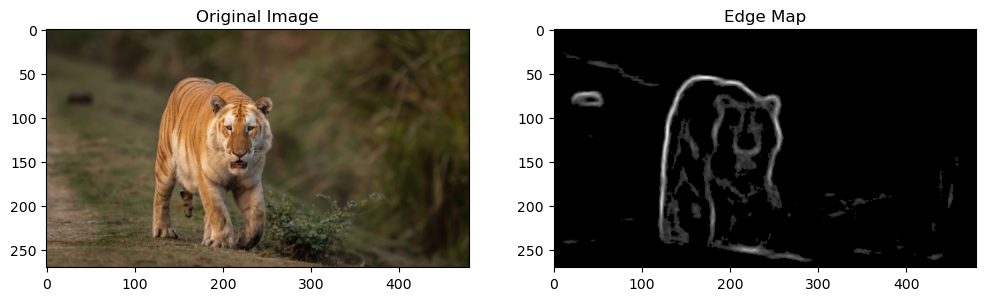

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque
import matplotlib.patches as patches
from scipy import ndimage
from collections import defaultdict

# from cv2.ximgproc import createStructuredEdgeDetection

MAGNITUDE_THRESHOLD = 0.1
SUM_MAG_THRESHOLD = 5
MAX_ITERATION = 200
img_path = "demo7_image.jpg"  # replace with your image path

def structured_edge_detection(img_path):
    # Read the image
    img = cv2.imread(img_path)
    # img = cv2.GaussianBlur(img, ksize=(5, 5), sigmaX=0.5)
    # Keep halving the image size until both width and height <= 1000
    while img.shape[0] > 600 or img.shape[1] > 600:
        img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2), interpolation=cv2.INTER_AREA)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # rgb = cv2.resize(rgb, (rgb.shape[1] // 4, rgb.shape[0] // 4), interpolation=cv2.INTER_AREA)

    # Create the edge detector
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection("model.yml.gz")
    
    # Normalize to [0, 1]
    img_float = img.astype(np.float32) / 255.0
    
    # Detect edges
    edges = edge_detector.detectEdges(img_float)

    # print(type(edges))

    # Apply threshold
    edges_threshold = np.where(edges >= MAGNITUDE_THRESHOLD, edges, 0) # .astype(np.uint8) * 255
    # # Apply threshold
    # edges_threshold = np.where(edges >= MAGNITUDE_THRESHOLD, 1, 0).astype(np.uint8) * 255

    # # Optional thinning
    # edges_thinned = cv2.ximgproc.thinning(edges_threshold)
    
    return rgb, edges_threshold

# Example usage
rgb_img, edge_map = structured_edge_detection(img_path)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(rgb_img), plt.title("Original Image")
plt.subplot(122), plt.imshow(edge_map, cmap='gray'), plt.title("Edge Map")
plt.show()

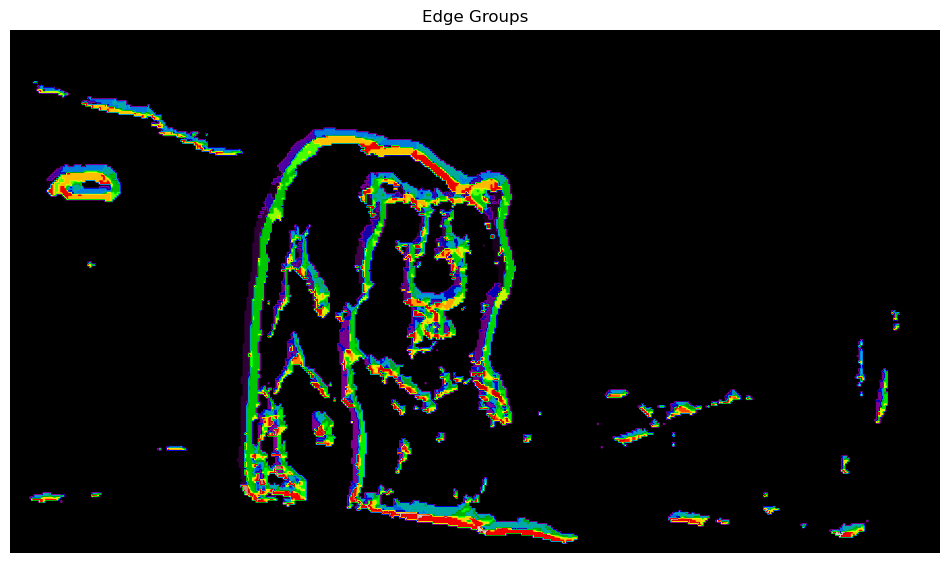

Number of edge groups: 2049


In [2]:
def quantize_angle(angle_rad):
    # Map angle from [-pi, pi] to [0, 8)
    angle_deg = np.rad2deg(angle_rad) % 360
    bins = ((angle_deg + 22.5) // 45).astype(int) % 8  # 8 directions, every 45°
    return bins

def group_edges_by_orientation(edge_map):
    # Compute gradient (note: edge_map is float)
    dx = cv2.Sobel(edge_map, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(edge_map, cv2.CV_32F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(dx**2 + dy**2)
    gradient_angle = np.arctan2(dy, dx)

    # Quantize orientations into 8 directions (0~7)
    orientation_bins = quantize_angle(gradient_angle)

    # Init group label map
    H, W = edge_map.shape
    group_labels = np.zeros((H, W), dtype=np.int32)
    current_label = 1

    for direction in range(8):
        mask = (orientation_bins == direction) & (edge_map > 0)

        # Connected component labeling for each direction
        labeled, ncomponents = ndimage.label(mask, structure=np.ones((3, 3)))
        labeled[labeled > 0] += current_label  # Avoid label conflict
        group_labels += labeled
        current_label += ncomponents

    return group_labels

group_labels = group_edges_by_orientation(edge_map)

def merge_edge_groups_by_orientation(group_labels, gradient_angle, angle_threshold=np.pi/4):
    """
    Merge edge groups that are close in direction and adjacent.
    
    Args:
        group_labels: group ID for each pixel (H x W)
        gradient_angle: gradient direction at each pixel (radians)
        angle_threshold: max allowed angle difference (radians)

    Returns:
        merged_labels: group label map after merging
    """
    H, W = group_labels.shape
    labels = group_labels.copy()
    next_label = labels.max() + 1

    # Compute mean orientation for each group
    group_orient = {}
    for g in range(1, labels.max() + 1):
        mask = (labels == g)
        if np.any(mask):
            mean_angle = np.arctan2(
                np.mean(np.sin(gradient_angle[mask])),
                np.mean(np.cos(gradient_angle[mask]))
            )
            group_orient[g] = mean_angle

    # Traverse each pixel, check if neighbor groups can be merged
    for y in range(1, H - 1):
        for x in range(1, W - 1):
            g1 = labels[y, x]
            if g1 == 0:
                continue
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    ny, nx = y + dy, x + dx
                    g2 = labels[ny, nx]
                    if g2 == 0 or g2 == g1:
                        continue
                    angle_diff = np.abs(group_orient[g1] - group_orient[g2])
                    if angle_diff > np.pi:
                        angle_diff = 2 * np.pi - angle_diff
                    if angle_diff < angle_threshold:
                        # Merge g2 → g1 (use smaller index to absorb larger)
                        to_change = (labels == g2)
                        labels[to_change] = g1
                        # Update orientation
                        angle_1 = group_orient[g1]
                        angle_2 = group_orient[g2]
                        group_orient[g1] = np.arctan2(
                            np.sin(angle_1) + np.sin(angle_2),
                            np.cos(angle_1) + np.cos(angle_2)
                        )
                        del group_orient[g2]

    return labels

# # 1. Compute gradient direction
# dx = cv2.Sobel(edge_map, cv2.CV_32F, 1, 0, ksize=3)
# dy = cv2.Sobel(edge_map, cv2.CV_32F, 0, 1, ksize=3)
# gradient_angle = np.arctan2(dy, dx) % (2 * np.pi)

# # 2. Greedy grouping + merge small groups
# group_labels = group_edges_greedy(edge_map, gradient_angle)

# Visualize label map (each group in different color)
plt.figure(figsize=(12, 12))
plt.imshow(group_labels, cmap='nipy_spectral')
plt.title("Edge Groups")
plt.axis('off')
plt.show()

num_groups = group_labels.max()
print(f"Number of edge groups: {num_groups}")


Number of remaining edge groups after filtering: 55


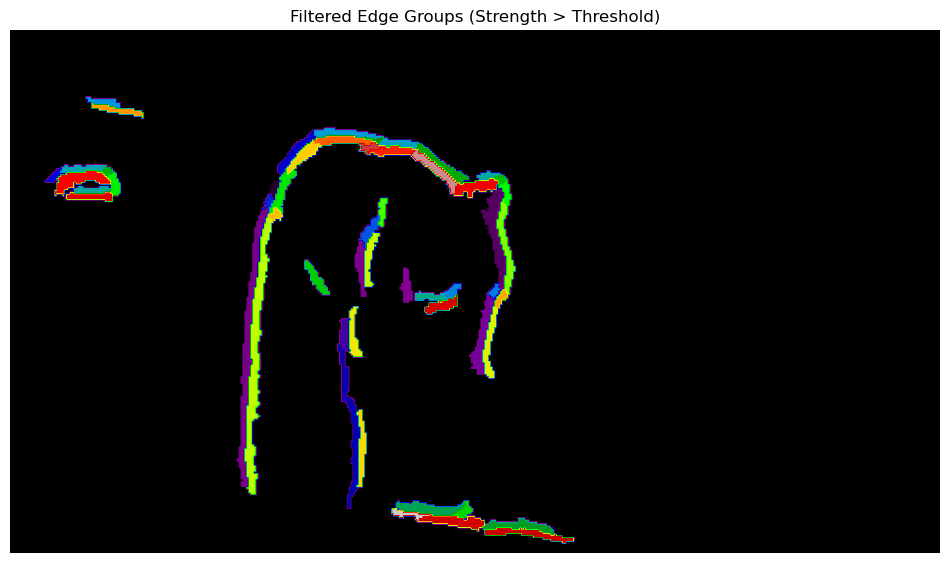

In [3]:
def filter_weak_edge_groups(group_labels, edge_strength, angle_map, mag_threshold=8.0):
    """
    Filter out groups whose total edge strength is below the threshold,
    and merge their pixels into nearby valid groups with the most similar orientation.
    
    Args:
        group_labels: original group ID per pixel (H x W)
        edge_strength: edge magnitude map (H x W)
        angle_map: edge orientation per pixel (in radians)
        mag_threshold: threshold below which groups are removed or merged

    Returns:
        filtered_labels: updated group label map
        group_info: info of each valid group (mag_sum, center)
    """
    H, W = group_labels.shape
    filtered_labels = np.zeros_like(group_labels)
    valid_label = 1
    group_info = {}
    num_groups = group_labels.max()

    # Step 1: compute total strength of each group, keep valid ones
    keep_groups = set()
    group_mag = {}
    for g in range(1, num_groups + 1):
        mask = (group_labels == g)
        mag_sum = edge_strength[mask].sum()
        if mag_sum >= mag_threshold:
            keep_groups.add(g)
            group_mag[g] = mag_sum

    # Step 2: assign new labels, store group_info
    group_mapping = {}  # original group id -> new valid_label
    for g in sorted(keep_groups):
        mask = (group_labels == g)
        filtered_labels[mask] = valid_label
        coords = np.column_stack(np.where(mask))
        center = coords.mean(axis=0)
        group_info[valid_label] = {
            'mag_sum': group_mag[g],
            'center': center
        }
        group_mapping[g] = valid_label
        valid_label += 1

    # Step 3: process removed groups (merge pixels into nearest valid group with closest direction)
    for y in range(1, H - 1):
        for x in range(1, W - 1):
            g = group_labels[y, x]
            if g == 0 or g in keep_groups:
                continue  # already kept, skip
            ref_angle = angle_map[y, x]
            best_label = 0
            best_diff = np.pi

            # search neighbors for valid groups with smallest angle diff
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    ny, nx = y + dy, x + dx
                    if not (0 <= ny < H and 0 <= nx < W):
                        continue
                    ng = group_labels[ny, nx]
                    if ng == 0 or ng not in keep_groups:
                        continue
                    angle_diff = abs(angle_map[ny, nx] - ref_angle)
                    if angle_diff > np.pi:
                        angle_diff = 2 * np.pi - angle_diff
                    if angle_diff < best_diff:
                        best_diff = angle_diff
                        best_label = group_mapping[ng]

            if best_label > 0:
                filtered_labels[y, x] = best_label
                group_info[best_label]['mag_sum'] += edge_strength[y, x]
                group_info[best_label]['center'] = (group_info[best_label]['center'] + [y, x]) / 2

    return filtered_labels, group_info


dx = cv2.Sobel(edge_map, cv2.CV_32F, 1, 0, ksize=3)
dy = cv2.Sobel(edge_map, cv2.CV_32F, 0, 1, ksize=3)
gradient_angle = np.arctan2(dy, dx) % (2 * np.pi)

# # Apply filter
# filtered_group_labels, group_info = filter_weak_edge_groups(group_labels, edge_map)

filtered_labels, group_info = filter_weak_edge_groups(
    group_labels,
    edge_strength=edge_map,
    angle_map=gradient_angle,  # should already be computed
    mag_threshold=SUM_MAG_THRESHOLD
)

# filtered_labels = merge_edge_groups_by_orientation(filtered_labels, gradient_angle)

# Show number of remaining groups
print(f"Number of remaining edge groups after filtering: {len(group_info)}")

# Visualize filtered group map
plt.figure(figsize=(12, 12))
plt.imshow(filtered_labels, cmap='nipy_spectral')
plt.title("Filtered Edge Groups (Strength > Threshold)")
plt.axis('off')
plt.show()


In [4]:
def compute_neighbor_dict(group_labels, connectivity=8):
    """
    Build a neighbor list for each edge group.

    Args:
        group_labels: HxW numpy array, indicating group label for each pixel (0 = non-edge)
        connectivity: 4- or 8-connectivity (default 8)

    Returns:
        neighbor_dict: dict[group_id] = [neighbor group_id1, group_id2, ...]
    """
    H, W = group_labels.shape
    neighbor_dict = defaultdict(set)

    if connectivity == 4:
        offsets = [(-1, 0), (0, -1), (1, 0), (0, 1)]
    elif connectivity == 8:
        offsets = [(-1, -1), (-1, 0), (-1, 1),
                   ( 0, -1),          ( 0, 1),
                   ( 1, -1), ( 1, 0), ( 1, 1)]
    else:
        raise ValueError("connectivity must be 4 or 8")

    for y in range(1, H - 1):
        for x in range(1, W - 1):
            g1 = group_labels[y, x]
            if g1 == 0:
                continue
            for dy, dx in offsets:
                ny, nx = y + dy, x + dx
                g2 = group_labels[ny, nx]
                if g2 != 0 and g2 != g1:
                    neighbor_dict[g1].add(g2)
                    neighbor_dict[g2].add(g1)

    # Convert sets to lists for output
    return {gid: list(neighs) for gid, neighs in neighbor_dict.items()}

def compute_group_orientations(group_labels, gradient_angle):
    """
    Compute the dominant orientation of each group in radians, range [0, 2π)

    Args:
        group_labels: H x W numpy array, group ID per pixel (0 = non-edge)
        gradient_angle: H x W numpy array, per-pixel gradient angle in radians

    Returns:
        orientation_dict: dict[group_id] = orientation
    """
    orientation_dict = {}
    group_ids = np.unique(group_labels)
    group_ids = group_ids[group_ids > 0]  # ignore 0 (non-edge)

    for gid in group_ids:
        mask = (group_labels == gid)
        angles = gradient_angle[mask]
        if angles.size == 0:
            continue
        # Average orientation using vector mean to avoid wrap-around issues
        mean_angle = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
        if mean_angle < 0:
            mean_angle += 2 * np.pi  # ensure within [0, 2π)
        orientation_dict[gid] = mean_angle

    return orientation_dict

import numpy as np

def get_box_boundary_groups(group_labels, box, margin=1):
    """
    Get all group IDs that touch the boundary of the given box (i.e. S_b)

    Args:
        group_labels: H x W numpy array, per-pixel group ID
        box: (x, y, w, h)
        margin: boundary contact margin (pixels)

    Returns:
        boundary_group_ids: set of group IDs touching the box boundary
    """
    x, y, w, h = box
    x1, y1 = x, y
    x2, y2 = x + w, y + h
    H, W = group_labels.shape

    x1m = max(0, x1)
    y1m = max(0, y1)
    x2m = min(W, x2)
    y2m = min(H, y2)

    boundary_group_ids = set()

    # top
    if y1m + margin < y2m:
        boundary_group_ids.update(np.unique(group_labels[y1m:y1m+margin, x1m:x2m]))
    # bottom
    if y2m - margin > y1m:
        boundary_group_ids.update(np.unique(group_labels[y2m-margin:y2m, x1m:x2m]))
    # left
    if x1m + margin < x2m:
        boundary_group_ids.update(np.unique(group_labels[y1m:y2m, x1m:x1m+margin]))
    # right
    if x2m - margin > x1m:
        boundary_group_ids.update(np.unique(group_labels[y1m:y2m, x2m-margin:x2m]))

    boundary_group_ids.discard(0)  # remove background
    return boundary_group_ids

def get_group_centers(group_info):
    """
    Build a mapping from group_id to center point (x, y)

    Args:
        group_info: dict[group_id] -> {'center': (y, x), ...}

    Returns:
        center_lookup: dict[group_id] -> (x, y)
    """
    center_lookup = {
        gid: (float(v['center'][1]), float(v['center'][0]))
        for gid, v in group_info.items()
    }
    return center_lookup

import networkx as nx
from scipy.spatial.distance import cdist

def build_affinity_graph(group_info, neighbor_dict, group_labels, gamma=2, pixel_dist_thresh=2.0, affinity_thresh=0.05):
    """
    Build the affinity graph (undirected), using EdgeBoxes affinity definition:
    
    a(s_i, s_j) = |cos(θ_i - θ_ij) * cos(θ_j - θ_ij)|^γ

    Only consider neighbors whose closest pixel distance <= pixel_dist_thresh.

    Args:
        group_info: dict[group_id] -> {'center': (y, x), 'orientation': radians}
        neighbor_dict: dict[group_id] -> [neighbor group ids]
        group_labels: H x W label map
        gamma: controls sensitivity to angle difference (use γ = 2 as in paper)
        pixel_dist_thresh: threshold for min pixel-to-pixel distance
        affinity_thresh: minimum affinity to keep edge

    Returns:
        G: NetworkX undirected graph, nodes = group_id, edge weights = affinity
    """
    G = nx.Graph()
    H, W = group_labels.shape

    # Collect pixels per group
    group_pixels = {}
    for gid in group_info:
        ys, xs = np.where(group_labels == gid)
        if len(xs) == 0:
            continue
        group_pixels[gid] = np.column_stack((xs, ys))  # (x, y)

        G.add_node(gid)

    for gid, neighbors in neighbor_dict.items():
        if gid not in group_info or gid not in group_pixels:
            continue

        theta_i = group_info[gid].get('orientation', None)
        xi_y, xi_x = group_info[gid]['center']
        xi = np.array([xi_x, xi_y])
        pixels_i = group_pixels[gid]

        for nid in neighbors:
            if nid not in group_info or nid not in group_pixels or G.has_edge(gid, nid):
                continue

            theta_j = group_info[nid].get('orientation', None)
            xj_y, xj_x = group_info[nid]['center']
            xj = np.array([xj_x, xj_y])
            pixels_j = group_pixels[nid]

            if theta_i is None or theta_j is None:
                continue

            dists = cdist(pixels_i, pixels_j)
            if np.min(dists) > pixel_dist_thresh:
                continue  # too far, skip

            theta_ij = np.arctan2(xj_y - xi_y, xj_x - xi_x)
            affinity = np.abs(np.cos(theta_i - theta_ij) * np.cos(theta_j - theta_ij)) ** gamma

            if affinity >= affinity_thresh:
                G.add_edge(gid, nid, weight=affinity)

    return G

def compute_wb_with_affinity(group_labels, group_info, box, affinity_graph, boundary_groups, center_lookup, box_margin=1):
    """
    Compute w_b(s_i) for each group s_i in the candidate box,
    considering affinity paths to boundary groups.
    If a group is fully enclosed by the box, set w_b=1 directly.

    Args:
        group_labels: HxW label map
        group_info: dict[group_id] -> {'mag_sum': ..., 'center': (y, x)}
        box: (x, y, w, h)
        affinity_graph: NetworkX graph with edge weights a(i, j)
        boundary_groups: set of group IDs touching the box boundary
        center_lookup: dict[group_id] -> (x, y)
        box_margin: margin tolerance for touching the box boundary

    Returns:
        wb_dict: dict[group_id] -> w_b(s_i)
    """
    import numpy as np
    x, y, w, h = box
    x1, y1 = x, y
    x2, y2 = x + w, y + h
    H, W = group_labels.shape

    wb_dict = {}

    for gid, info in group_info.items():
        if gid in boundary_groups:
            wb_dict[gid] = 0.0
            continue

        mask = (group_labels == gid)
        ys, xs = np.where(mask)
        if len(xs) == 0:
            wb_dict[gid] = 0.0
            continue

        if xs.min() >= x1 and xs.max() < x2 and ys.min() >= y1 and ys.max() < y2:
            wb_dict[gid] = 1.0
            continue

        max_product = 0.0
        for b_gid in boundary_groups:
            try:
                path = nx.shortest_path(affinity_graph, source=b_gid, target=gid)
                product = 1.0
                for i in range(len(path) - 1):
                    product *= affinity_graph[path[i]][path[i + 1]]['weight']
                max_product = max(max_product, product)
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                continue

        wb = 1.0 - max_product if max_product > 0 else 1.0
        wb_dict[gid] = wb

    return wb_dict

neighbor_dict = compute_neighbor_dict(filtered_labels)

orientation_dict = compute_group_orientations(filtered_labels, gradient_angle)

for gid, theta in orientation_dict.items():
    group_info[gid]['orientation'] = theta

affinity_graph = build_affinity_graph(
    group_info=group_info,
    neighbor_dict=neighbor_dict,
    group_labels=filtered_labels,
    gamma=2,
    pixel_dist_thresh=3.0,
    affinity_thresh=0.05
)

In [5]:
def score_edge_box(
    box,
    group_labels,
    group_info,
    edge_map,
    affinity_graph,
    box_margin=1,
    kappa=1.5,
    debug=False
):
    """
    Full EdgeBoxes scoring function, includes path affinity w_b(s_i), penalty terms, and correction terms.

    Args:
        box: candidate box (x, y, w, h)
        group_labels: group label per pixel
        group_info: mag_sum and center for each group
        edge_map: edge strength map
        affinity_graph: group-level affinity graph
        box_margin: pixel margin to determine if group touches box boundary
        kappa: normalization factor
        debug: if True, prints detailed scoring info

    Returns:
        final_score: score value (the higher the better)
    """
    import numpy as np

    H, W = group_labels.shape
    x, y, w, h = box

    # Step 1: groups that touch the boundary
    boundary_group_ids = get_box_boundary_groups(group_labels, box, margin=box_margin)

    # Step 2: center lookup
    center_lookup = get_group_centers(group_info)

    # Step 3: use affinity paths to compute w_b(s_i)
    wb_dict = compute_wb_with_affinity(
        group_labels=group_labels,
        group_info=group_info,
        box=box,
        affinity_graph=affinity_graph,
        boundary_groups=boundary_group_ids,
        center_lookup=center_lookup,
        box_margin=box_margin
    )

    # Step 4: forward score + penalty correction
    all_gids = np.unique(group_labels[y:y+h, x:x+w])
    weighted_sum = 0.0
    penalty_correction = 0.0
    
    for gid in all_gids:
        if gid == 0 or gid not in group_info:
            continue
    
        mag = group_info[gid]['mag_sum']
        wb = wb_dict.get(gid, 1.0)  # default to fully enclosed

        weighted_sum += wb * mag

        if 0 < wb < 1:
            penalty_correction += (1 - wb) * mag

            # penalty_correction += ((1 - wb) ** 2) * mag

    normalized_score = (weighted_sum - penalty_correction) / (2 * (w + h) ** kappa)

    # Step 5: central region penalty
    cx = x + w // 2
    cy = y + h // 2
    half_w = w // 4
    half_h = h // 4
    in_x1 = max(0, cx - half_w)
    in_x2 = min(W, cx + half_w)
    in_y1 = max(0, cy - half_h)
    in_y2 = min(H, cy + half_h)
    center_sum = edge_map[in_y1:in_y2, in_x1:in_x2].sum()
    penalty_center = center_sum / (2 * (w + h) ** kappa)

    # Step 6: small box penalty (currently zero, can be tuned later)
    penalty_small = 0.0

    # Step 7: final score
    final_score = normalized_score - penalty_center - penalty_small
    # final_score = normalized_score - penalty_small

    # Step 8: debug print
    if debug:
        print("==== Debug EdgeBox Score ====")
        print("Box:", box)
        print("Weighted Sum:", weighted_sum)
        print("Correction Term:", penalty_correction)
        print("Normalized Score:", normalized_score)
        print("Penalty Center Region:", penalty_center)
        print("Final Score:", final_score)

    return final_score

Best Box: (95, 58, 167, 207)
Best Score: 0.04722552005587043


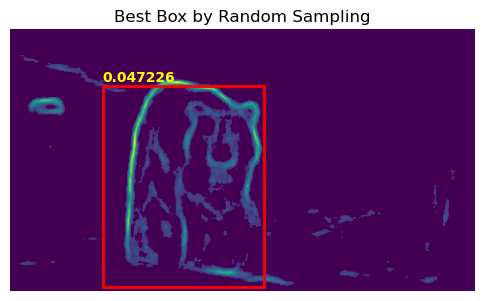

In [6]:
import numpy as np
import random

def sample_random_boxes(H, W, n=10000, min_size=30, max_size_ratio=0.8):
    """
    Randomly sample n valid boxes from the image.
    """
    boxes = []
    for _ in range(n):
        w = random.randint(min_size, int(W * max_size_ratio))
        h = random.randint(min_size, int(H * max_size_ratio))
        x = random.randint(0, W - w)
        y = random.randint(0, H - h)
        boxes.append((x, y, w, h))
    return boxes

def find_best_box_by_sampling(edge_map, group_labels, group_info, affinity_graph,
                               n_samples=10000, min_size=30, max_size_ratio=0.8,
                               kappa=1.5):
    """
    Sample n_samples random boxes, compute score for each using the full scoring function,
    and return the one with the highest score.
    """
    H, W = edge_map.shape
    boxes = sample_random_boxes(H, W, n=n_samples, min_size=min_size, max_size_ratio=max_size_ratio)

    best_box = None
    best_score = -float('inf')

    for box in boxes:
        score = score_edge_box(
            box=box,
            group_labels=group_labels,
            group_info=group_info,
            edge_map=edge_map,
            affinity_graph=affinity_graph,
            box_margin=1,
            kappa=kappa,
            debug=False  # set to True to debug score details
        )
        if score > best_score:
            best_score = score
            best_box = box

    return best_box, best_score

top_boxes, top_scores = find_best_box_by_sampling(
    edge_map=edge_map,
    group_labels=filtered_labels,
    group_info=group_info,
    affinity_graph=affinity_graph,
    n_samples=300,  # number of sampled boxes
    min_size=120,
    max_size_ratio=0.8
)

print("Best Box:", top_boxes)
print("Best Score:", top_scores)

import matplotlib.pyplot as plt
import cv2

def show_box_on_edge_map(edge_map, box, score):
    x, y, w, h = map(int, box)
    plt.figure(figsize=(6, 6))
    plt.imshow(edge_map, cmap='viridis')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, fill=False))
    plt.text(x, y - 5, f"{score:.6f}", color='yellow', fontsize=10, fontweight='bold')
    plt.title("Best Box by Random Sampling")
    plt.axis("off")
    plt.show()

show_box_on_edge_map(edge_map, top_boxes, top_scores)


[Iter 0] !!! Improved: 0.0534 @ (108, 36, 162, 234)
[Iter 1] ... No improvement, trying fresh random directions.
[Iter 2] ... No improvement, trying fresh random directions.
[Iter 3] ... No improvement, trying fresh random directions.
[Iter 4] ... No improvement, trying fresh random directions.
[Iter 5] ... No improvement, trying fresh random directions.
[Iter 6] ... No improvement, trying fresh random directions.
[Iter 7] ... No improvement, trying fresh random directions.
[Iter 8] ... No improvement, trying fresh random directions.
[Iter 9] ... No improvement, trying fresh random directions.
[Iter 10] !!! Improved: 0.0584 @ (112, 43, 147, 227)
[Iter 11] ... No improvement, trying fresh random directions.
[Iter 12] ... No improvement, trying fresh random directions.
[Iter 13] ... No improvement, trying fresh random directions.
[Iter 14] ... No improvement, trying fresh random directions.
[Iter 15] ... No improvement, trying fresh random directions.
[Iter 16] ... No improvement, trying

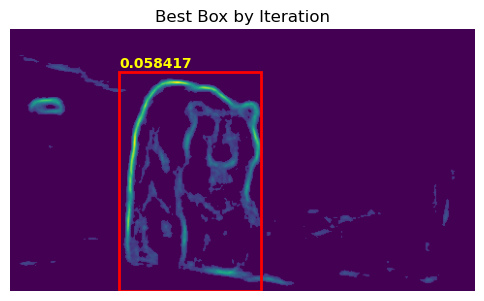

In [7]:
def refine_box_random_walk(
    init_box,
    edge_map,
    group_labels,
    group_info,
    affinity_graph,
    max_iter=30,
    delta_pos=20,
    delta_size=30,
    trials_per_iter=10,
    kappa=1.5,
    debug=False
):
    """
    Random perturbation + greedy update: at each iteration try several random boxes,
    accept the first that improves score, then continue.
    """
    import random

    H, W = edge_map.shape
    x, y, w, h = init_box
    best_box = (x, y, w, h)
    best_score = score_edge_box(
        box=best_box,
        group_labels=group_labels,
        group_info=group_info,
        edge_map=edge_map,
        affinity_graph=affinity_graph,
        kappa=kappa
    )

    for i in range(max_iter):
        improved = False
        for _ in range(trials_per_iter):
            dx = random.randint(-delta_pos, delta_pos)
            dy = random.randint(-delta_pos, delta_pos)
            dw = random.randint(-delta_size, delta_size)
            dh = random.randint(-delta_size, delta_size)

            new_x = max(0, min(W - 1, x + dx))
            new_y = max(0, min(H - 1, y + dy))
            new_w = max(10, min(W - new_x, w + dw))
            new_h = max(10, min(H - new_y, h + dh))

            new_box = (new_x, new_y, new_w, new_h)
            new_score = score_edge_box(
                box=new_box,
                group_labels=group_labels,
                group_info=group_info,
                edge_map=edge_map,
                affinity_graph=affinity_graph,
                kappa=kappa
            )

            if new_score > best_score:
                best_box = new_box
                best_score = new_score
                x, y, w, h = new_box  # update current position
                improved = True
                if debug:
                    print(f"[Iter {i}] !!! Improved: {new_score:.4f} @ {new_box}")
                break  # accept improvement and break → next iteration

        if not improved:
            if debug:
                print(f"[Iter {i}] ... No improvement, trying fresh random directions.")

    return best_box, best_score

refined_box, refined_score = refine_box_random_walk(
    init_box=top_boxes,
    edge_map=edge_map,
    group_labels=filtered_labels,
    group_info=group_info,
    affinity_graph=affinity_graph,
    max_iter=MAX_ITERATION,
    delta_pos=70,
    delta_size=50,
    trials_per_iter=8,
    debug=True
)

def show_result(edge_map, box, score):
    x, y, w, h = map(int, box)
    plt.figure(figsize=(6, 6))
    plt.imshow(edge_map, cmap='viridis')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, fill=False))
    plt.text(x, y - 5, f"{score:.6f}", color='yellow', fontsize=10, fontweight='bold')
    plt.title("Best Box by Iteration")
    plt.axis("off")
    plt.show()

print("Refined Box:", refined_box)
print("Refined Score:", refined_score)

show_result(edge_map, refined_box, refined_score)


Refined Box: (112, 43, 147, 227)
Refined Score: 0.05841654572253353


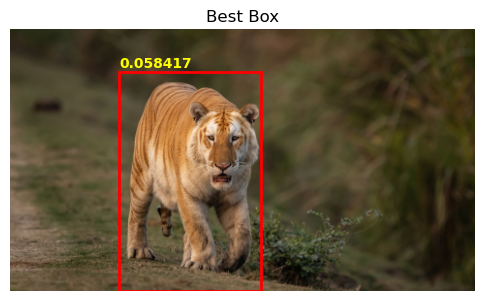

In [8]:
def show_rgb(edge_map, box, score):
    x, y, w, h = map(int, box)
    plt.figure(figsize=(6, 6))
    plt.imshow(edge_map, cmap='viridis')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, fill=False))
    plt.text(x, y - 5, f"{score:.6f}", color='yellow', fontsize=10, fontweight='bold')
    plt.title("Best Box")
    plt.axis("off")
    plt.show()


print("Refined Box:", refined_box)
print("Refined Score:", refined_score)

show_rgb(rgb_img, refined_box, refined_score)